In [1]:
import os 
import pickle
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
# !python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

CODE_PATH = os.getcwd()
BASE_PATH = os.path.abspath(os.path.join(CODE_PATH, ".."))
DATA_PATH = os.path.join(BASE_PATH, "Data")
MODEL_PATH = os.path.join(BASE_PATH, "Model")
os.chdir(BASE_PATH)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\14183\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Data

In [3]:
#load data
data = pd.read_csv(os.path.join(DATA_PATH, 'Reviews.csv'))
data.head()
print(data.shape)

(568454, 10)


In [3]:
#select useful columns
cols = ['ProductId', 'UserId', 'Score', 'Text']
select_data = data[cols]
select_data.head()

,ProductId,UserId,Score,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


## Preprocess Data

### Label Sentiment

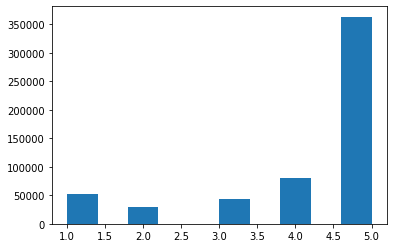

In [4]:
#visulize the distribution of scores
plt.hist(select_data["Score"])
plt.show()

In [5]:
#split the data
train_data, test_data = train_test_split(select_data, random_state=0, test_size=0.3)

In [6]:
sentiment_label = {1: "positive",
                 0: "neutral",
                 -1: "negative"}
def label_sentiment(data):
    data.loc[data['Score'] == 5, ["sentiment"]] = 1
    data.loc[data['Score'] == 4, ["sentiment"]] = 0
    data.loc[data['Score'] <= 3, ["sentiment"]] = -1
    return data


In [7]:
train_data = label_sentiment(train_data)
test_data = label_sentiment(test_data)
train_data.head()

,ProductId,UserId,Score,Text,sentiment
333546,B00188S3PM,A3IMFBFX5L85S9,2,I had a hard time drinking this tea as it tast...,-1.0
149769,B00004S1C5,A1KXONFPU2XQ5K,5,This are so much easier to use than the Wilson...,1.0
483649,B000LKTW5S,A2CH3AVJI0UR3P,5,I've had a bunch of these Indian food pouch th...,1.0
392300,B001EQ50U4,AKP5H95MFKI21,4,"I received this item as advertised, i.e. pack ...",0.0
1514,B003UIDAHY,A5WOFSMP2PI45,5,Great product. Recommended by Dr. Oz. We lov...,1.0


### Tokenize, lemmatize and remove stopping words

In [8]:
def tokenize(sentence,method='spacy'):
# Tokenize and lemmatize text, remove stopwords and punctuation

    punctuations = string.punctuation
    stopwords = list(STOP_WORDS)

    if method=='nltk':
        # Tokenize
        tokens = nltk.word_tokenize(sentence,preserve_line=True)
        # Remove stopwords and punctuation
        tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
        # Lemmatize
        wordnet_lemmatizer = WordNetLemmatizer()
        tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
        tokens = " ".join([i for i in tokens])
    else:
        # Tokenize
        with nlp.select_pipes(enable=['tokenizer','lemmatizer']):
            tokens = nlp(sentence)
        # Lemmatize
        tokens = [word.lemma_.lower().strip() for word in tokens]
        # Remove stopwords and punctuation
        tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
        tokens = " ".join([i for i in tokens])
    return tokens

In [9]:
# Process the training set text
tqdm.pandas()
train_data['processed_text'] = train_data['Text'].progress_apply(lambda x: tokenize(x,method='nltk'))

# Process the test set text
tqdm.pandas()
test_data['processed_text'] = test_data['Text'].progress_apply(lambda x: tokenize(x,method='nltk'))

100%|██████████| 170537/170537 [01:43<00:00, 1645.78it/s]


In [10]:
train_data.head()

,ProductId,UserId,Score,Text,sentiment,processed_text
333546,B00188S3PM,A3IMFBFX5L85S9,2,I had a hard time drinking this tea as it tast...,-1.0,I hard time drinking tea taste like cardboard ...
149769,B00004S1C5,A1KXONFPU2XQ5K,5,This are so much easier to use than the Wilson...,1.0,This easier use Wilson paste colors. Colors vi...
483649,B000LKTW5S,A2CH3AVJI0UR3P,5,I've had a bunch of these Indian food pouch th...,1.0,I bunch Indian food pouch thing probably best ...
392300,B001EQ50U4,AKP5H95MFKI21,4,"I received this item as advertised, i.e. pack ...",0.0,I received item advertised i.e. pack 2. No pro...
1514,B003UIDAHY,A5WOFSMP2PI45,5,Great product. Recommended by Dr. Oz. We lov...,1.0,Great product. Recommended Dr. Oz. We love pas...


## Create features using word counts

In [11]:
def build_features(train_data, test_data, ngram_range, method='count'):
    if method == 'tfidf':
        # Create features using TFIDF
        vec = TfidfVectorizer(ngram_range=ngram_range)
        X_train = vec.fit_transform(train_data['processed_text'])
        X_test = vec.transform(test_data['processed_text'])

    else:
        # Create features using word counts
        vec = CountVectorizer(ngram_range=ngram_range)
        X_train = vec.fit_transform(train_data['processed_text'])
        X_test = vec.transform(test_data['processed_text'])

    return X_train, X_test, vec

In [12]:
# Create features
method = 'tfidf'
ngram_range = (1, 2)
X_train,X_test, nlp = build_features(train_data,test_data,ngram_range,method)

## Train the model

In [13]:
# Train a classification model using logistic regression classifier
y_train = train_data['sentiment']
logreg_model = LogisticRegression(solver='saga')
logreg_model.fit(X_train,y_train)
preds = logreg_model.predict(X_train)
acc = sum(preds==y_train)/len(y_train)
print('Accuracy on the training set is {:.3f}'.format(acc))

Accuracy on the training set is 0.907


## Evaluate model

In [14]:
# Evaluate accuracy on the test set
y_test = test_data['sentiment']
test_preds = logreg_model.predict(X_test)
test_acc = sum(test_preds==y_test)/len(y_test)
print('Accuracy on the test set is {:.3f}'.format(test_acc))

Accuracy on the test set is 0.846


In [15]:
with open(os.path.join(MODEL_PATH, "tfidf.pickle"), 'wb') as f:
    pickle.dump(nlp, f)

with open(os.path.join(MODEL_PATH, "tfidf_reg.pickle"), 'wb') as f:
    pickle.dump(logreg_model, f)


In [16]:
train_data['sentiment_pred'] = logreg_model.predict(X_train)
test_data['sentiment_pred'] = logreg_model.predict(X_test)

In [17]:
train_data.head()

,ProductId,UserId,Score,Text,sentiment,processed_text,sentiment_pred
333546,B00188S3PM,A3IMFBFX5L85S9,2,I had a hard time drinking this tea as it tast...,-1.0,I hard time drinking tea taste like cardboard ...,-1.0
149769,B00004S1C5,A1KXONFPU2XQ5K,5,This are so much easier to use than the Wilson...,1.0,This easier use Wilson paste colors. Colors vi...,1.0
483649,B000LKTW5S,A2CH3AVJI0UR3P,5,I've had a bunch of these Indian food pouch th...,1.0,I bunch Indian food pouch thing probably best ...,1.0
392300,B001EQ50U4,AKP5H95MFKI21,4,"I received this item as advertised, i.e. pack ...",0.0,I received item advertised i.e. pack 2. No pro...,-1.0
1514,B003UIDAHY,A5WOFSMP2PI45,5,Great product. Recommended by Dr. Oz. We lov...,1.0,Great product. Recommended Dr. Oz. We love pas...,1.0


In [18]:
train_data.to_csv(os.path.join(DATA_PATH, "tfidf_train.csv"))
test_data.to_csv(os.path.join(DATA_PATH, "tfidf_test.csv"))

## Create bins for User sentiments and Product sentiments

In [4]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "tfidf_train.csv"), index_col=0)
test_data = pd.read_csv(os.path.join(DATA_PATH, "tfidf_test.csv"), index_col=0)

In [5]:
#compute the average sentiment for each user and product
user_sent = train_data.groupby(['UserId'])['sentiment'].agg(['count', 'mean']).reset_index()
prod_sent = train_data.groupby(['ProductId'])['sentiment'].agg(['count', 'mean']).reset_index()

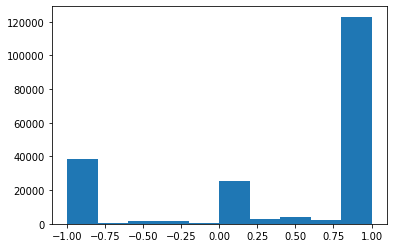

In [6]:
#visulize the distribution of sentiment
import matplotlib.pyplot as plt
plt.hist(user_sent['mean'])
plt.show()

In [7]:
def create_bins(data):
    #group the sentiment into bins according to its quantile
    n = 20
    q = [i/n for i in range(1, n)]
    quant = data['mean'].quantile(q)

    #create bins
    bins = list(set(quant))
    bins.sort(reverse=True)

    #map bins with sentiment
    data['bin_sent'] = len(bins)
    for i in range(len(bins)-1):
        idx = (data['mean'] < bins[i]) & (data['mean'] >= bins[i+1])
        data.loc[idx, ['bin_sent']] = len(bins) - i - 1
    
    return data

In [8]:
user_sent_bin = create_bins(user_sent)[['UserId', 'bin_sent']]
user_sent_bin.columns = ["UserId", "user_bin_sent"]
prod_sent_bin = create_bins(prod_sent)[['ProductId', 'bin_sent']]
prod_sent_bin.columns = ['ProductId', 'prod_bin_sent']

In [9]:
train_data = train_data.merge(user_sent_bin, how = "inner", left_on="UserId", right_on="UserId")
train_data = train_data.merge(prod_sent_bin, how = "inner", left_on="ProductId", right_on="ProductId")
test_data = test_data.merge(user_sent_bin, how = "inner", left_on="UserId", right_on="UserId")
test_data = test_data.merge(prod_sent_bin, how = "inner", left_on="ProductId", right_on="ProductId")

In [10]:
train_data.to_csv(os.path.join(DATA_PATH, "tfidf_train_bins.csv"), index = False)
test_data.to_csv(os.path.join(DATA_PATH, "tfidf_test_bins.csv"), index = False)